In [297]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from skimage.filters import threshold_otsu
from datetime import datetime
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
import seaborn as sns
from src.two_p.fish_data import FishData
import src.two_p.stimuli_timeline as st
import src.two_p.plotting as plott
import src.utils as utils
from IPython.display import display, HTML
display(HTML("<style>.output_scroll {height: 500px; overflow-y: scroll;}</style>"))

plt.style.use('default')
plt.rc('axes.spines', bottom=True, left=True, right=False, top=False)

#%matplotlib qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [298]:
import pathlib
try: # If on non-Windows, make WindowsPath behave like PosixPath
    pathlib.WindowsPath('C:\\')  # works on Windows
except NotImplementedError:
    pathlib.WindowsPath = pathlib.PosixPath


##### Define file paths

In [323]:
SYSTEM = "mac"
STORAGE = "hd"

DATA_ROOT = utils.get_data_paths(SYSTEM, STORAGE)
print("Root:", DATA_ROOT)

EXPERIMENT_NAME = "LR_thalamus_bout_exp01"
main_path = DATA_ROOT / EXPERIMENT_NAME
stimuli_path = main_path / 'stimuli'
plot_path = main_path / 'plots' / 'all_fish'

Root: /Volumes/LAB-MATI/Lausanne/2p


##### Define parameters

In [300]:
SELECTED_FISH = [18, 33, 37, 38, 39, 40, 41, 42, 43]
SELECTED_BLOCKS = [f'B{n}' for n in range(1, 3)]
N_PLANES = 5
FPS_2p = 2
FPS_stimuli = 60
FRAMES_per_BLOCK = 1560 #1650 # how many volumes we acquire for each block
duration_2p_block_sec = FRAMES_per_BLOCK / FPS_2p

##### Load stimuli durations

In [301]:
stimuli_ordered = ['LLB', 'LLC', 'RLB', 'RLC', 'LLB+RLB', 'LLB+RLC', 'LLC+RLB','LLC+RLC']
stimuli_duration = {}
for stim in stimuli_ordered:
    stim_file = next(stimuli_path.glob(f"{stim}_*trajectory.csv"))
    stimuli_duration[stim] = st.get_stimulus_timing(stim_file)

##### Load experiment stimuli traces

In [302]:
fish_data = {}

for fish_num in SELECTED_FISH:
    fish_id = f"f{fish_num:02d}"
    fish = FishData(fish_id, main_path, N_PLANES, FPS_2p, FPS_stimuli)
    fish.load_all(
        selected_blocks=SELECTED_BLOCKS,
        stimuli_duration=stimuli_duration,
        duration_2p_block_sec=duration_2p_block_sec
    )
    fish_data[fish_id] = fish

Loading f18
Loading f33
Loading f37
Loading f38
Loading f39
Loading f40
Loading f41
Loading f42
Loading f43


#### Step 0 - Filter neurons that respond to stimuli

In [347]:
# Extract all ΔF/F traces and their anatomical metadata
FISH_ID = "f18"
fish = fish_data[FISH_ID]
stimuli_trace = fish.stimuli_trace
fish.get_all_cell_traces()
print("Loaded traces:", fish.cell_traces.shape)

Loaded traces: (1142, 3120)


#### Average Intertrial correlation

imports, params, sanity checks

In [348]:
# peri-stimulus window in seconds
t_pre_s  = 5.0   # time before onset to include
t_post_s = 29.0  # time after onset to include

# convert to frames
pre_frames  = int(round(t_pre_s * fish.fps_2p))
post_frames = int(round(t_post_s * fish.fps_2p))
win_lenght = pre_frames + post_frames

# list which stimulus IDs are present in the trace (excluding 0)
stimuli_ids = sorted(int(x) for x in np.unique(stimuli_trace) if x != 0)
stimuli_names = fish.stimuli_names

# sanity checks
assert fish.cell_traces.ndim == 2, "traces must be (n_neurons, T)"
assert stimuli_trace.ndim == 1, "stim_trace must be (T,)"
assert fish.cell_traces.shape[1] == stimuli_trace.shape[0], "time dimension mismatch"
n_neurons, T = fish.cell_traces.shape

Find all present stimuli and their onset frames to build trial-aligned windows

In [349]:
onsets_by_id = {}
trial_aligned_traces = {}   # sid -> (n_neurons, win_lenght, n_trials)
n_trials_by_id = {}
dropped_onsets_by_id = {}

n_neurons, T = fish.cell_traces.shape

for stim in stimuli_ids:
    # find onsets frames (0→1 transitions)
    active = (stimuli_trace == stim).astype(np.int8)
    transitions = np.diff(active, prepend=0)
    onsets = np.flatnonzero(transitions == 1)
    onsets_by_id[stim] = onsets

    # create windows and slices neuron trace to generate
    starts = onsets - pre_frames
    ends   = onsets + post_frames
    keep   = (starts >= 0) & (ends <= T)

    # arr is trial-aligned neural activity windows for each stimulus
    # arr shape: (n_neurons, win_length, n_trials)
    if not np.any(keep):
        arr = np.empty((n_neurons, win_lenght, 0), dtype=float)
    else:
        arr = np.stack([fish.cell_traces[:, s:e] for s, e in zip(starts[keep], ends[keep])], axis=2)

    trial_aligned_traces[stim] = arr

    print(f"stim {stim}: {onsets.size} onsets | kept {arr.shape[2]} trials | dropped {np.count_nonzero(~keep)}")

stim 1: 4 onsets | kept 4 trials | dropped 0
stim 2: 4 onsets | kept 4 trials | dropped 0
stim 3: 4 onsets | kept 4 trials | dropped 0
stim 4: 4 onsets | kept 4 trials | dropped 0
stim 5: 4 onsets | kept 4 trials | dropped 0
stim 6: 4 onsets | kept 4 trials | dropped 0
stim 7: 4 onsets | kept 4 trials | dropped 0
stim 8: 4 onsets | kept 4 trials | dropped 0


Stimuli response reliability and threshold via Otsu

It measure the average trial-to-trial correlation of its activity in response to different stimuli. It then selects the maximum reliability across all stimuli for each neuron and applies an automatic threshold to identify reliably responding neurons.

Otsu’s method selects a data-driven cutoff that best separates two groups in a histogram by maximizing between-class variance. Ideally the your values come from two classes (e.g., “low” vs “high”), so the histogram is roughly bimodal with a valley in between and in the middle of the valley is where Otsu cuts. It does not work well with unimodal or very skewed distributions

In [350]:
# create array to store reliability metric
reliability_per_stim = np.full((n_neurons, len(stimuli_ids)), np.nan, dtype=float)

for j, stim in enumerate(stimuli_ids):
    aligned_neural_traces = trial_aligned_traces[stim] #(n_neurons, win_lenght, n_trials)

    for i in range(n_neurons):
        neuron_trace = aligned_neural_traces[i, :, :] # neuron trace 2D array (time, trials)

        # Compute trial-to-trial correlation matrix (shape: trials x trials)
        correlation_matrix = np.corrcoef(neuron_trace.T)

        # Ignore self-correlations by setting diagonal to NaN
        np.fill_diagonal(correlation_matrix, np.nan)

        # Compute mean correlation (reliability) across all trial pairs
        reliability_per_stim[i, j] = np.nanmean(correlation_matrix) #

# Compute max reliability value across all stimuli and filter out nan values
max_stimuli_correlation = np.nanmax(reliability_per_stim, axis=1)
nanfiltered_max_stimuli_correlation = max_stimuli_correlation[np.isfinite(max_stimuli_correlation)] # select only finite (not nan values)
otsu_threshold = threshold_otsu(nanfiltered_max_stimuli_correlation)

#Build keep mask in the original neuron space (not nanfiltered) and get indices
kept_mask = np.isfinite(max_stimuli_correlation) & (max_stimuli_correlation >= otsu_threshold)
kept_neuron_indices = np.flatnonzero(kept_mask) #return indices where the values are true

Histogram

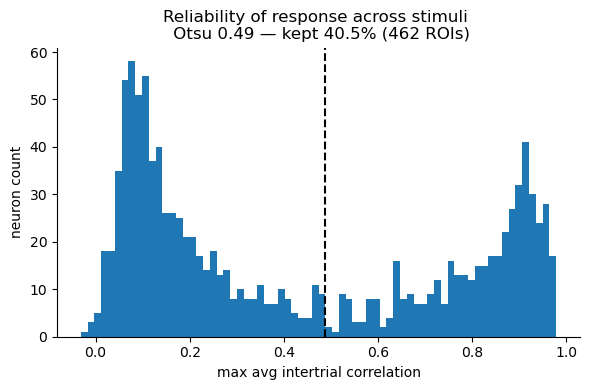

In [351]:
hist_bins = 70
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(nanfiltered_max_stimuli_correlation, bins=hist_bins)
kept_pct = (100.0 * kept_neuron_indices.size / n_neurons) if n_neurons else 0.0
ax.axvline(otsu_threshold, linestyle="--", color="k")
ax.set(title=f"Reliability of response across stimuli \n Otsu {otsu_threshold:.2f} — kept {kept_pct:.1f}% ({kept_neuron_indices.size} ROIs)",
       xlabel="max avg intertrial correlation", ylabel="neuron count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

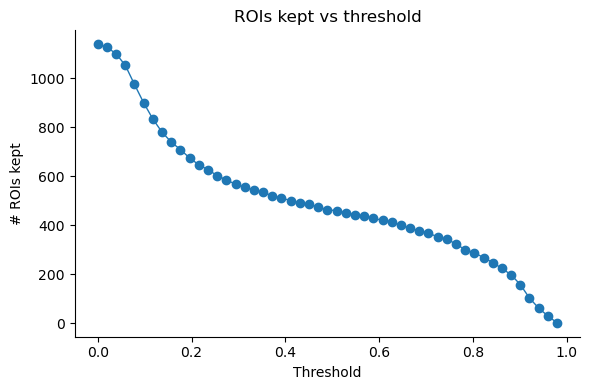

In [352]:
low = max(0.0, float(np.nanmin(nanfiltered_max_stimuli_correlation)))
high = min(1.0, max(float(np.nanmax(nanfiltered_max_stimuli_correlation)), low + 1e-6))
thr_grid = np.linspace(low, high, 51)

counts = [np.sum(nanfiltered_max_stimuli_correlation >= thr) for thr in thr_grid]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(thr_grid, counts, marker="o", linewidth=1)
ax.set(title="ROIs kept vs threshold",
       xlabel="Threshold", ylabel="# ROIs kept")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

#### Step 1 - Stimuli selectivity

Quality check of baseline distribution in the frames before the start of a trial

Suggestion: SKIP baseline subtraction (offsets/spread within tolerances).


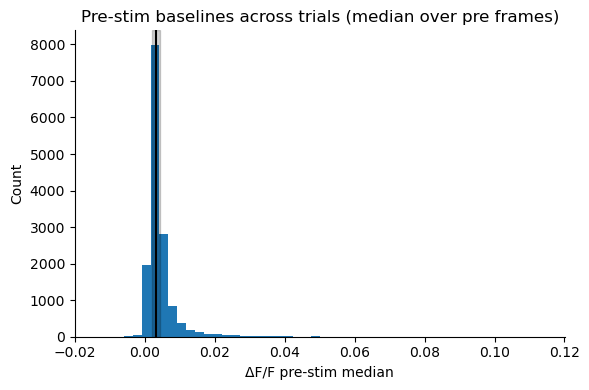

In [353]:
medians_all = []

for stim in stimuli_ids:
    X = trial_aligned_traces[stim]                 # (n_neurons, win_lenght, n_trials)
    if X.shape[2] == 0:
        continue
    Xi = X[kept_neuron_indices, :pre_frames, :]             # (n_sel, pre_frames, n_trials)
    medians = np.nanmedian(Xi, axis=1)             # (n_sel, n_trials)
    medians_all.append(medians.ravel())

medians_flat = np.concatenate(medians_all) if len(medians_all) else np.array([], dtype=float)
global_median = float(np.nanmedian(medians_flat)) if medians_flat.size else np.nan
mad = float(np.nanmedian(np.abs(medians_flat - global_median))) if medians_flat.size else np.nan
frac_large = float(np.mean(np.abs(medians_flat) > 0.01)) if np.isfinite(medians_flat).any() else np.nan  # >1% ΔF/F

# --- Simple decision rules (loose, safe defaults) ---
tol_median = 0.005   # 0.5% ΔF/F
tol_spread = 0.005   # 0.5% ΔF/F
tol_frac   = 0.10    # >10% of trials show >1% offset

reasons = []
if abs(global_median) > tol_median:
    reasons.append(f"|median| > {tol_median:.3f}")
if mad > tol_spread:
    reasons.append(f"MAD > {tol_spread:.3f}")
if np.isfinite(frac_large) and (frac_large > tol_frac):
    reasons.append(f">{int(tol_frac*100)}% trials |baseline| > 0.01")

do_subtract = len(reasons) > 0
if do_subtract:
    print("Suggestion: SUBTRACT baseline (reasons: " + ", ".join(reasons) + ").")
else:
    print("Suggestion: SKIP baseline subtraction (offsets/spread within tolerances).")

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(medians_flat[np.isfinite(medians_flat)], bins=50)
ax.axvline(global_median, linestyle="-", color="k")
lo, hi = global_median - mad, global_median + mad
ax.axvspan(lo, hi, alpha=0.18, label=f"MAD band [{lo:.4f}, {hi:.4f}]", color="k")

ax.set(title="Pre-stim baselines across trials (median over pre frames)",
       xlabel="ΔF/F pre-stim median", ylabel="Count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

Trial-average traces and compute ΔF/F peak and AUC

In [354]:
dt = 1.0 / float(fish.fps_2p) #time per frame (the sampling interval) in seconds

# Containers (per stimulus → arrays of shape (n_kept,))
mean_traces = {}   # trial-averaged timecourses (kept neurons)
peaks = {}
aucs  = {}
averages = {}

for stim in stimuli_ids:
    X = trial_aligned_traces[stim]                      # (n_neurons, win_lenght, n_trials)
    Xkept = X[kept_neuron_indices, :, :]                   # filter kept neurons
    mean_trace = np.nanmean(Xkept, axis=2)                # (kept_neurons, win_lenght)
    mean_traces[stim] = mean_trace

    # Stimulus window (without pre stim frames)
    Y = mean_trace[:, pre_frames:win_lenght]                # (n_kept, n_post)
    peaks[stim] = np.nanmax(Y, axis=1) # peak ΔF/F
    aucs[stim]  = np.trapezoid(np.nan_to_num(Y), dx=dt, axis=1)  # AUC (ΔF/F * s), NaNs→0
    averages[stim] = np.nanmean(Y, axis=1)

Compute indices

In [355]:
L_ids = [1]
R_ids = [3]
bout_ids = [1, 3, 5]
continous_ids = [2, 4, 8]

n_kept_neurons = kept_neuron_indices.size

# 1) Collect features by group (works for both PEAKS and AUCS)
groups = {"L": L_ids, "R": R_ids, "bout": bout_ids, "continous": continous_ids}
metrics = {"peak": peaks, "auc":  aucs, 'average': averages}

# group_mats[metric][group][max/mean] = (n_kept_neurons, )
# e.g. group_matrix['peaks']['L']['mean
group_matrix = {g: {m: {} for m in metrics} for g in groups}
for g, id_list in groups.items():
    for m, m_dict in metrics.items():
        cols = [m_dict[stim].reshape(-1, 1) for stim in id_list] # transform into 1 column for each stim (neurons x stim)
        matrix = np.concatenate(cols, axis=1) # concatenate the list into an array
        group_matrix[g][m]['mean'] = np.nanmean(matrix, axis=1)
        group_matrix[g][m]['max'] = np.nanmax(matrix, axis=1)

# 3) Preference indices: neg, pos, key    INDEX = (pos − neg) / (pos + neg)
pairs = [("L", "R", "LR"), ("continous", "bout", "bpi")]

indices = {key: {} for neg, pos, key in pairs} # final structure eg. indices['LR']['auc']['mean']
for neg, pos, key in pairs:
    for m in metrics:
        indices[key][m] = {}
        for agg in ("max", "mean"):
            A = group_matrix[pos][m][agg]
            B = group_matrix[neg][m][agg]
            num = A - B
            den = A + B
            bad = (~np.isfinite(num)) | (~np.isfinite(den)) | (np.abs(den) < 1e-12)
            idx = num / den
            idx[bad] = np.nan
            indices[key][m][agg] = idx #index val

Extract relevant variables

In [356]:
metric = "auc"
BPI_THRESHOLD = 0.2
bpi_auc_mean= indices["bpi"][metric]["mean"] # shape (n reliable neurons,)
bpi_mask = np.isfinite(bpi_auc_mean) & (bpi_auc_mean > BPI_THRESHOLD)
n_sel = bpi_mask.sum()
perc_bp = np.mean(bpi_auc_mean > BPI_THRESHOLD) * 100

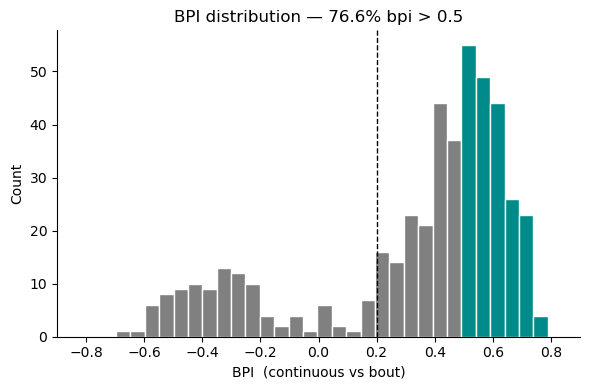

In [357]:
# --- histogram ---
fig, ax = plt.subplots(figsize=(6, 4))
counts, edges, patches = ax.hist(bpi_auc_mean, bins=30, edgecolor='white', color='gray')

# recolor only bars whose bin center > 0.5
centers = BPI_THRESHOLD * (edges[:-1] + edges[1:])
for c, p in zip(centers, patches):
    if c > BPI_THRESHOLD:
        p.set_facecolor('darkcyan')


# add vertical line at 0.5
ax.axvline(BPI_THRESHOLD, color='black', linestyle='--', linewidth=1)
ax.set_xlim(-0.9, 0.9)
ax.set(    title=f"BPI distribution — {perc_bp:.1f}% bpi > 0.5",
       xlabel="BPI  (continuous vs bout)", ylabel="Count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()


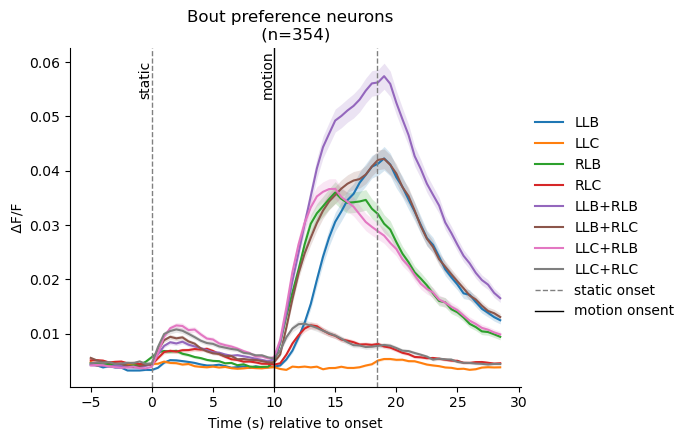

In [358]:
# Time axis in seconds, 0 at stimulus onset ---
fps_val = float(fish.fps_2p)  # keep your source for fps
t = (np.arange(win_lenght) - pre_frames) / fps_val

# Plot: one curve per stimulus = mean across selected neurons ---
fig, ax = plt.subplots(figsize=(7, 4.5))
color_by_stim = {}
for i, stim in enumerate(stimuli_ids):
    M = mean_traces[stim]            # (n_kept_neurons, win_lenght)
    Ms = M[bpi_mask, :]                  # (n_sel, win_lenght)
    trace_mean = np.nanmean(Ms, axis=0)       # (win_lenght,)
    trace_sd   = np.nanstd(Ms, axis=0)
    trace_sem  = trace_sd / np.sqrt(n_sel)       # SEM across neurons

    line, = ax.plot(t, trace_mean, label=stimuli_names[i])
    color_by_stim[stim] = line.get_color()
    ax.fill_between(t, trace_mean - trace_sem, trace_mean + trace_sem,
                    alpha=0.18, color=line.get_color(), linewidth=0)

# visual guides
ax.axvline(0.0, linestyle="--", linewidth=1, label="static onset", color='grey')  # stimulus onset
ax.text(-0.5, 0.85, "static", rotation=90, va="bottom", ha="center", transform=ax.get_xaxis_transform())
ax.axvline(10, linewidth=1, color='k', label='motion onsent')  # stimulus onset
ax.text(9.5, 0.85, "motion", rotation=90, va="bottom", ha="center", transform=ax.get_xaxis_transform())
ax.axvline(18.4, linestyle="--", linewidth=1, color='grey')  # stimulus onset

ax.set(title=f"Bout preference neurons  \n (n={n_sel}) ", xlabel="Time (s) relative to onset", ylabel=" ΔF/F ")
# style: no top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# legend on the right, vertically centered
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5),  borderaxespad=0.0)

plt.subplots_adjust(right=0.78)
plt.tight_layout()
plt.show()

In [359]:
bpi_order = np.argsort(bpi_auc_mean)  # ascending
start_s = 15 # soconds after the start of the stimulus window to plot
start_ix = int(start_s * fish.fps_2p)
bpi_sorted = bpi_auc_mean[bpi_order]
palette = sns.diverging_palette(220, 20, l=40, s=90, as_cmap=True)
#palette = plt.cm.coolwarm

# --- concatenate all stimuli horizontally ---
blocks = [mean_traces[stim][bpi_order, start_ix:] for stim in stimuli_ids]
bigmat = np.concatenate(blocks, axis=1)

# boundaries: cumulative sum of widths (start indices for bars/labels)
block_widths    = [blk.shape[1] for blk in blocks]
stim_boundaries = np.r_[0, np.cumsum(block_widths[:-1])]
stim_centers    = stim_boundaries + np.array(block_widths) / 2

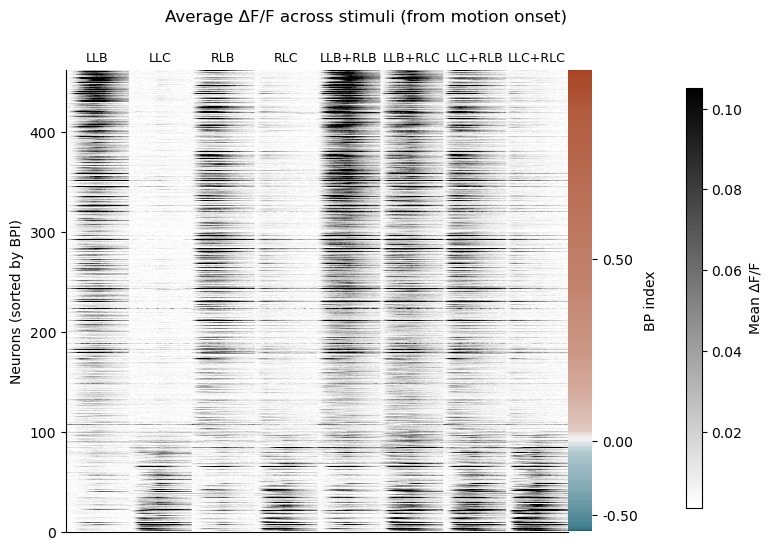

In [360]:
# robust color scaling
vmin, vmax = np.nanpercentile(bigmat, [2, 98])

# figure with a dedicated colorbar axis
fig = plt.figure(figsize=(8, 6))
gs  = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[40, 2], wspace=0.35)
ax = fig.add_subplot(gs[0, 0])

# heatmap (extent to avoid half-pixel padding)
H, W = bigmat.shape
im = ax.imshow(bigmat, aspect="auto", origin="lower", cmap="gray_r", vmin=vmin, vmax=vmax, extent=[0, W, 0, H]) #extend avoid padding at the left and right border of the heatmap
ax.set_xlim(0, W); ax.set_ylim(0, H)
ax.set_ylabel("Neurons (sorted by BPI)")
ax.set_xticks([])
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

# create a new axis for the LR index strip
bbox = ax.get_position()
ax_bpi = fig.add_axes([bbox.x1, bbox.y0, 0.03,bbox.height])  # left edge (slightly to the right of heatmap), bottom aligned, width (2% of figure),  same height as heatmap

bpi_norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(bpi_sorted), vcenter=0, vmax=np.nanmax(bpi_sorted))
ax_bpi.imshow(bpi_sorted[:, None], aspect="auto", origin="lower", cmap=palette, norm=bpi_norm, extent=[0, 1, 0, H])

# ticks at specific LR values
targets = np.array([0.0, 0.5, -0.5])
idxs = np.abs(bpi_sorted[:, None] - targets).argmin(0)# find nearest rows for these values

ax_bpi.set_xticks([])
ax_bpi.set_yticks(idxs + 0.5)  # +0.5 to center ticks on rows
ax_bpi.set_yticklabels([f"{t:.2f}" for t in targets])
ax_bpi.yaxis.set_ticks_position("right")
ax_bpi.yaxis.set_label_position("right")
ax_bpi.set_ylabel("BP index")

for spine in ("top", "bottom", "left"):
    ax_bpi.spines[spine].set_visible(False)

# stimulus labels above each block
y_bar = 1.01
for xc, label in zip(stim_centers, stimuli_names):
    #ax.hlines(y=y_bar, xmin=start, xmax=start + win_len, colors=color_by_stim[stim], linewidth=3, transform=ax.get_xaxis_transform(), clip_on=False, zorder=10)
    ax.text(xc, y_bar, label, ha="center", va="bottom", fontsize=9, transform=ax.get_xaxis_transform(), clip_on=False)

# --- add ΔF/F colorbar farther out on the right ---
cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in fig coords
cb = fig.colorbar(im, cax=cax)
cb.set_label("Mean ΔF/F")

fig.suptitle("Average ΔF/F across stimuli (from motion onset)")
plt.show()

In [361]:
all_stimuli_selective_neurons = {f'plane{i}': [] for i in range(N_PLANES)}

for i, n in enumerate(kept_neuron_indices):
    plane, neuron_idx = fish.cell_metadata[n].values()  # e.g. plane='plane0', neuron_idx within that plane's stat list
    all_stimuli_selective_neurons[plane].append([neuron_idx, float(bpi_auc_mean[i])])

/var/folders/vw/c25xvnd9261_m9fn18n8vf040000gn/T/ipykernel_3549/939511493.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


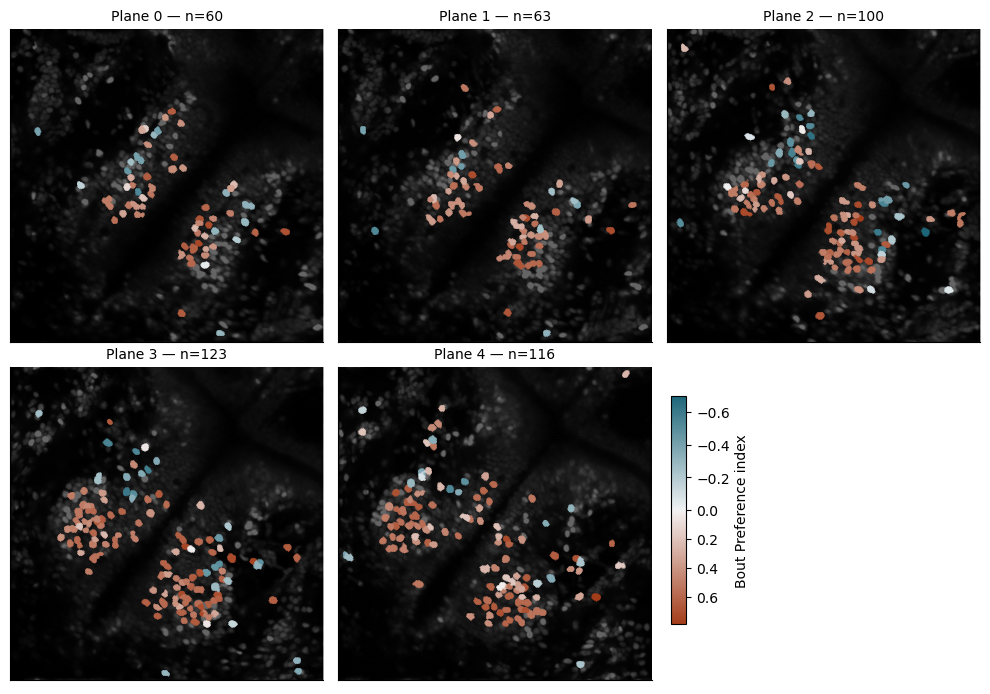

In [362]:
# plotting
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # 2 rows × 3 cols (one extra slot)
axes = axes.ravel()

for p in range(N_PLANES):  # N_PLANES = 5
    ops = fish.data[f'plane{p}']['ops']
    mean_img = ops['meanImg']

    # contrast meanImg clipping & normalization (1–99th percentiles)
    p1, p99 = np.percentile(mean_img, (1, 99))
    denom = (p99 - p1) if (p99 - p1) != 0 else 1.0
    mean_img_norm = np.clip(mean_img, p1, p99)
    mean_img_norm = (mean_img_norm - p1) / denom

    stat_list = fish.data[f'plane{p}']['stat']
    entries = all_stimuli_selective_neurons[f'plane{p}']

    ax = axes[p]
    gamma = 0.8
    mean_img_gamma = mean_img_norm ** gamma
    ax.set_facecolor("black")
    ax.imshow(mean_img_gamma, cmap='gray', origin='lower', alpha=.4)

    # plot each ROI colored by its LR index
    for roi_idx, bpi_val in entries:
        st = stat_list[roi_idx]
        ax.plot(st['xpix'], st['ypix'], '.', markersize=0.8, color=palette(bpi_norm(bpi_val)),alpha=1)

    ax.set_title(f"Plane {p} — n={len(entries)}", fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# hide the unused subplot (6 slots, 5 planes → 1 empty)
for j in range(N_PLANES, len(axes)):
    axes[j].axis("off")

sm = plt.cm.ScalarMappable(cmap=palette, norm=bpi_norm)
sm.set_array([])

last_ax = axes[N_PLANES-1]        # last used axis (plane4)
bbox = last_ax.get_position()      # in figure coordinates

# [left, bottom, width, height] in figure coords
cax = fig.add_axes([bbox.x1 + 0.05, bbox.y0 - 0.015, 0.015, bbox.height])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Bout Preference index")
#cbar.set_ticks([-0.6, -0.3, 0, 0.3, 0.6])
cbar.ax.invert_yaxis()

plt.tight_layout()
plt.show()

Left-Right index

In [363]:
lri_auc_mean = indices["LR"]["auc"]["mean"]
left_mask_kept = bpi_mask & (lri_auc_mean < 0)# (n_kept_neurons,)
right_mask_kept = bpi_mask & (lri_auc_mean > 0)
masks = [left_mask_kept, right_mask_kept]
l_pref_lri = lri_auc_mean[left_mask_kept]   # Left-pref
r_pref_lri = lri_auc_mean[right_mask_kept]   # Right-pref
all_pref_lri = lri_auc_mean[bpi_mask]

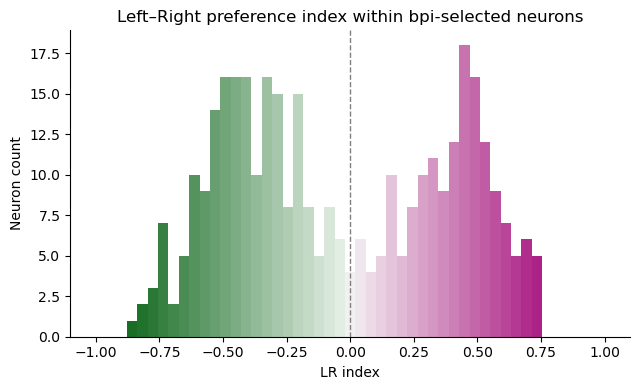

In [364]:
# bins and colormap
bins = np.linspace(-1, 1, 50)
palette = sns.diverging_palette(130, 330, l=40, s=90, as_cmap=True)

#palette = plt.cm.managua
norm = mcolors.TwoSlopeNorm(vmin=all_pref_lri.min(), vcenter=0, vmax=all_pref_lri.max())

#norm = mcolors.Normalize(vmin=all_pref.min(), vmax=all_pref.max())
# plot
fig, ax = plt.subplots(figsize=(6.5, 4.0))
counts, edges, patches = ax.hist(all_pref_lri, bins=bins, alpha=1, edgecolor='none')

# color bins by their centers (vectorized)
centers = 0.5 * (edges[:-1] + edges[1:])
colors = palette(norm(centers))
for p, c in zip(patches, colors):
    p.set_facecolor(c)

# zero line & styling
ax.axvline(0, linestyle='--', linewidth=1, color='grey')
ax.set(title="Left–Right preference index within bpi-selected neurons", xlabel="LR index", ylabel="Neuron count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

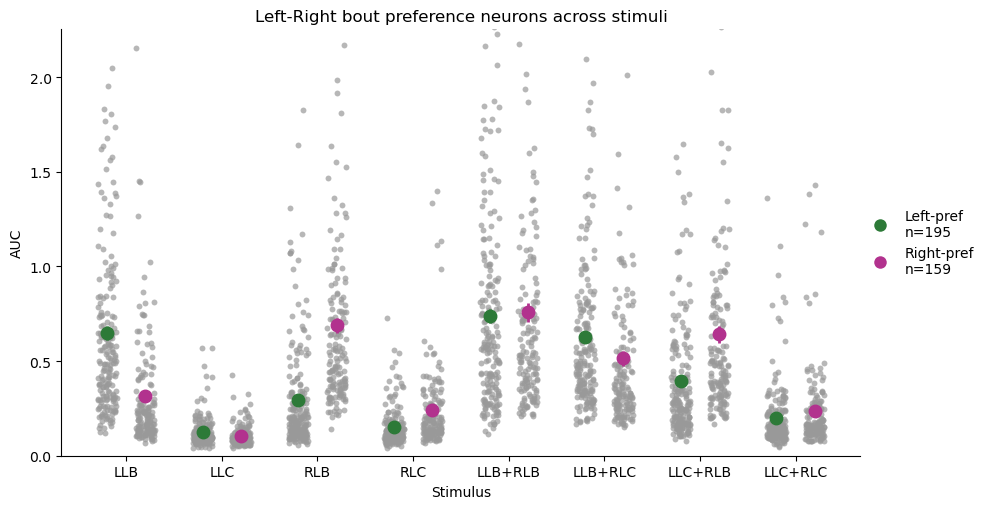

In [365]:
# --- styling & jitter ---
rng = np.random.default_rng(42)
half_offset, jitter_amp, marker_size = 0.2, 0.1, 18

# --- x positions & labels ---
x = np.arange(len(stimuli_ids), dtype=float)
xticklabels = [stimuli_names[i] for i, _ in enumerate(stimuli_ids)]

# --- strong endpoint colors from PiYG_r (green @ low end, pink @ high end) ---
left_col  = palette(0.05)   # strong green (neg / left-pref)
right_col = palette(0.95)   # strong pink  (pos / right-pref)

fig, ax = plt.subplots(figsize=(10, 5.2))

for i, stim in enumerate(stimuli_ids):
    vals  = aucs[stim]  # (n_kept_neurons,)
    auc_L = vals[left_mask_kept]
    auc_R = vals[right_mask_kept]

    # scatter with horizontal jitter (vectorized)
    xL = x[i] - half_offset + rng.uniform(-jitter_amp, jitter_amp, auc_L.size)
    xR = x[i] + half_offset + rng.uniform(-jitter_amp, jitter_amp, auc_R.size)
    ax.scatter(xL, auc_L, s=marker_size, color='0.6', alpha=0.7, linewidths=0)
    ax.scatter(xR, auc_R, s=marker_size, color='0.6', alpha=0.7, linewidths=0)

    # mean ± SEM overlays
    if auc_L.size:
        mean_L = np.nanmean(auc_L)
        sem_L  = np.nanstd(auc_L, ddof=1) / np.sqrt(auc_L.size) if auc_L.size > 1 else np.nan
        ax.errorbar(x[i] - half_offset, mean_L, yerr=sem_L, fmt="o",
                    color=left_col, capsize=0, lw=2, ms=9, zorder=3)
    if auc_R.size:
        mean_R = np.nanmean(auc_R)
        sem_R  = np.nanstd(auc_R, ddof=1) / np.sqrt(auc_R.size) if auc_R.size > 1 else np.nan
        ax.errorbar(x[i] + half_offset, mean_R, yerr=sem_R, fmt="o",
                    color=right_col, capsize=0, lw=2, ms=9, zorder=3)

# x / y, labels, and limits
ax.set_xticks(x)
ax.set_xticklabels(xticklabels)
pooled = np.concatenate([aucs[s][left_mask_kept] for s in stimuli_ids] + [aucs[s][right_mask_kept] for s in stimuli_ids])
y_hi = float(np.nanpercentile(pooled, 99))
ax.set_ylim(0, y_hi)
ax.set(title="Left-Right bout preference neurons across stimuli",ylabel="AUC", xlabel="Stimulus")

# cosmetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend using the strong endpoint colors
legend_handles = [Line2D([0], [0], marker='o', color='none', markeredgecolor='none',markerfacecolor=left_col, markersize=9, label=f"Left-pref\nn={l_pref_lri.size}"),
                  Line2D([0], [0], marker='o', color='none', markeredgecolor='none',markerfacecolor=right_col,markersize=9, label=f"Right-pref\nn={r_pref_lri.size}")]

ax.legend(handles=legend_handles, frameon=False, loc="center left",bbox_to_anchor=(1, 0.5), borderaxespad=0.0)

plt.subplots_adjust(right=0.78)
plt.tight_layout()
plt.show()

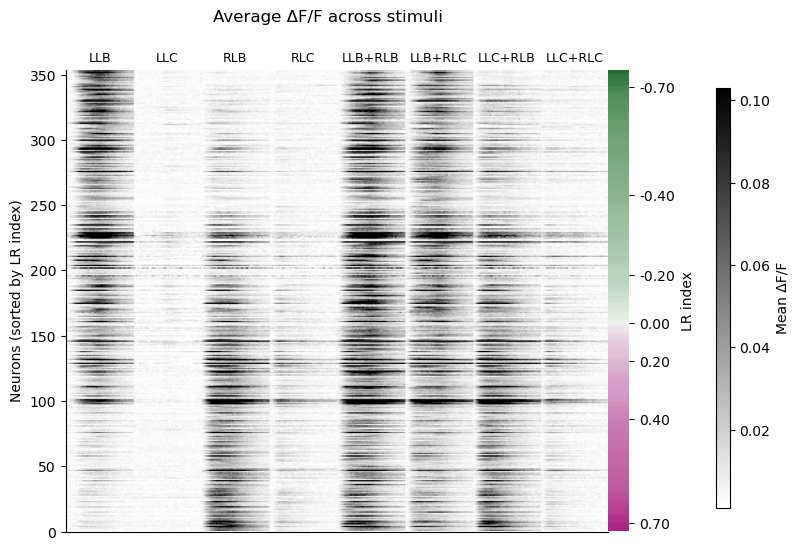

In [366]:
order_lr = np.argsort(all_pref_lri)[::-1]                      # ascending by LR index
lr_sorted = all_pref_lri[order_lr]

# ---- build the concatenated matrix (rows reordered by LR) ----
start_ix = int(start_s * fish.fps_2p)
blocks = [mean_traces[stim][bpi_mask][order_lr, start_ix:] for stim in stimuli_ids] # (neurons x time)
bigmat = np.concatenate(blocks, axis=1)

# boundaries/centers for labels (optional)
block_widths = [blk.shape[1] for blk in blocks]
stim_boundaries = np.r_[0, np.cumsum(block_widths[:-1])]
stim_centers = stim_boundaries + np.array(block_widths) / 2

# ---- robust color scaling for activity heatmap ----
vmin, vmax = np.nanpercentile(bigmat, [2, 98])

# --- base figure with heatmap ---
fig, ax = plt.subplots(figsize=(7, 6))
H, W = bigmat.shape
im = ax.imshow(bigmat, aspect="auto", origin="lower", cmap="gray_r", vmin=vmin, vmax=vmax, extent=[0, W, 0, H])
ax.set_xlim(0, W); ax.set_ylim(0, H)
ax.set_ylabel("Neurons (sorted by LR index)")
ax.set_xticks([])
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

# create a new axis for the LR index strip
bbox = ax.get_position()
ax_lr = fig.add_axes([bbox.x1, bbox.y0, 0.03,bbox.height])  # left edge (slightly to the right of heatmap), bottom aligned, width (2% of figure),  same height as heatmap

lr_norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(lr_sorted), vcenter=0, vmax=np.nanmax(lr_sorted))
ax_lr.imshow(lr_sorted[:, None], aspect="auto", origin="lower", cmap=palette, norm=lr_norm, extent=[0, 1, 0, H])

# ticks at specific LR values
targets = np.array([-0.7, -0.4, -0.2, 0.0, 0.2, 0.4, 0.7])
idxs = np.abs(lr_sorted[:, None] - targets).argmin(0)# find nearest rows for these values

ax_lr.set_xticks([])
ax_lr.set_yticks(idxs + 0.5)  # +0.5 to center ticks on rows
ax_lr.set_yticklabels([f"{t:.2f}" for t in targets])
ax_lr.yaxis.set_ticks_position("right")
ax_lr.yaxis.set_label_position("right")
ax_lr.set_ylabel("LR index")

for spine in ("top", "bottom", "left"):
    ax_lr.spines[spine].set_visible(False)

y_bar = 1.01
for xc, label in zip(stim_centers, stimuli_names):
    ax.text(xc, y_bar, label, ha="center", va="bottom", fontsize=9, transform=ax.get_xaxis_transform(), clip_on=False)

# --- add ΔF/F colorbar farther out on the right ---
cax = fig.add_axes([1.053, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in fig coords
cb = fig.colorbar(im, cax=cax)
cb.set_label("Mean ΔF/F")

fig.suptitle("Average ΔF/F across stimuli")
plt.show()

Back to anatomy

In [367]:
# collect (roi_idx_within_plane, lr_value) per plane
vals_by_plane = {f'plane{i}': [] for i in range(N_PLANES)} #
left_by_plane = {f'plane{i}': [] for i in range(N_PLANES)}
right_by_plane = {f'plane{i}': [] for i in range(N_PLANES)}

for i, n in enumerate(kept_neuron_indices[bpi_mask]):
    plane, neuron_idx = fish.cell_metadata[n].values()  # e.g. plane='plane0', neuron_idx within that plane's stat list
    vals_by_plane[plane].append([neuron_idx, float(all_pref_lri[i])])

for n in kept_neuron_indices[left_mask_kept]:
    plane, neuron_idx = fish.cell_metadata[n].values()
    left_by_plane[plane].append(neuron_idx)

for n in kept_neuron_indices[right_mask_kept]:
    plane, neuron_idx = fish.cell_metadata[n].values()
    right_by_plane[plane].append(neuron_idx)

/var/folders/vw/c25xvnd9261_m9fn18n8vf040000gn/T/ipykernel_3549/1700707570.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


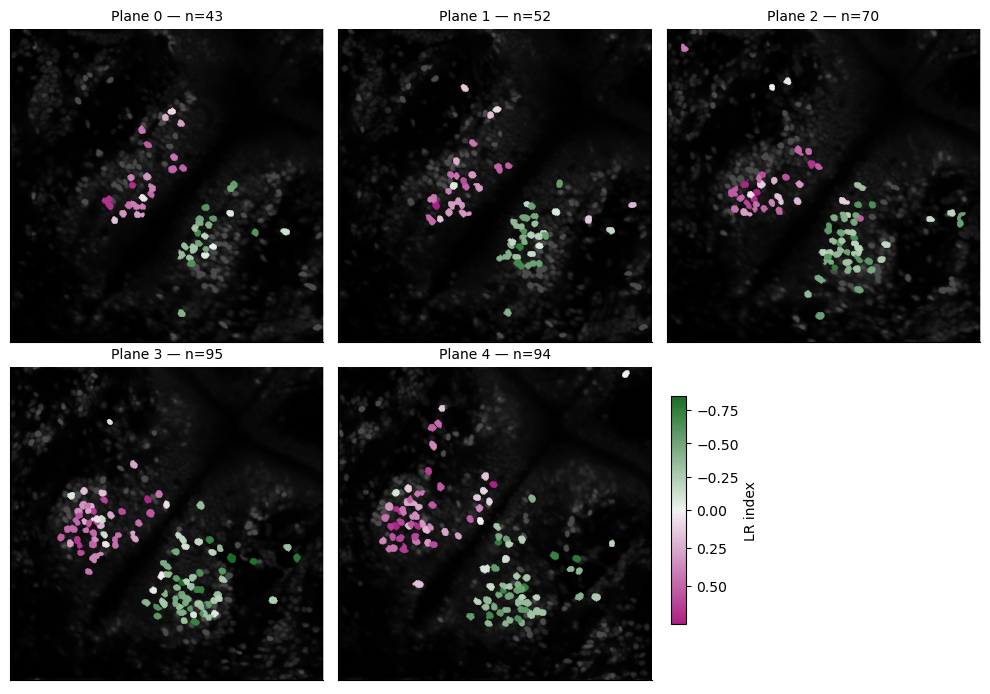

In [368]:
# plotting
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # 2 rows × 3 cols (one extra slot)
axes = axes.ravel()

for p in range(N_PLANES):  # N_PLANES = 5
    ops = fish.data[f'plane{p}']['ops']
    mean_img = ops['meanImg']

    # contrast meanImg clipping & normalization (1–99th percentiles)
    p1, p99 = np.percentile(mean_img, (1, 99))
    denom = (p99 - p1) if (p99 - p1) != 0 else 1.0
    mean_img_norm = np.clip(mean_img, p1, p99)
    mean_img_norm = (mean_img_norm - p1) / denom

    stat_list = fish.data[f'plane{p}']['stat']
    entries = vals_by_plane[f'plane{p}']

    ax = axes[p]
    ax.set_facecolor("black")
    gamma = .8
    mean_img_gamma = mean_img_norm ** gamma
    ax.imshow(mean_img_gamma, cmap='gray', origin='lower', alpha=.3)

    # plot each ROI colored by its LR index
    for roi_idx, lr_val in entries:
        st = stat_list[roi_idx]
        ax.plot(st['xpix'], st['ypix'], '.', markersize=0.8, color=palette(norm(lr_val)),alpha=1)

    ax.set_title(f"Plane {p} — n={len(entries)}", fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# hide the unused subplot (6 slots, 5 planes → 1 empty)
for j in range(N_PLANES, len(axes)):
    axes[j].axis("off")

sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

last_ax = axes[N_PLANES-1]        # last used axis (plane4)
bbox = last_ax.get_position()      # in figure coordinates

# [left, bottom, width, height] in figure coords
cax = fig.add_axes([bbox.x1 + 0.05, bbox.y0 - 0.015, 0.015, bbox.height])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("LR index")
#cbar.set_ticks([-0.6, -0.3, 0, 0.3, 0.6])
cbar.ax.invert_yaxis()

plt.tight_layout()
plt.savefig(plot_path / f"{FISH_ID}_lri_to_anatomy.pdf")

plt.show()

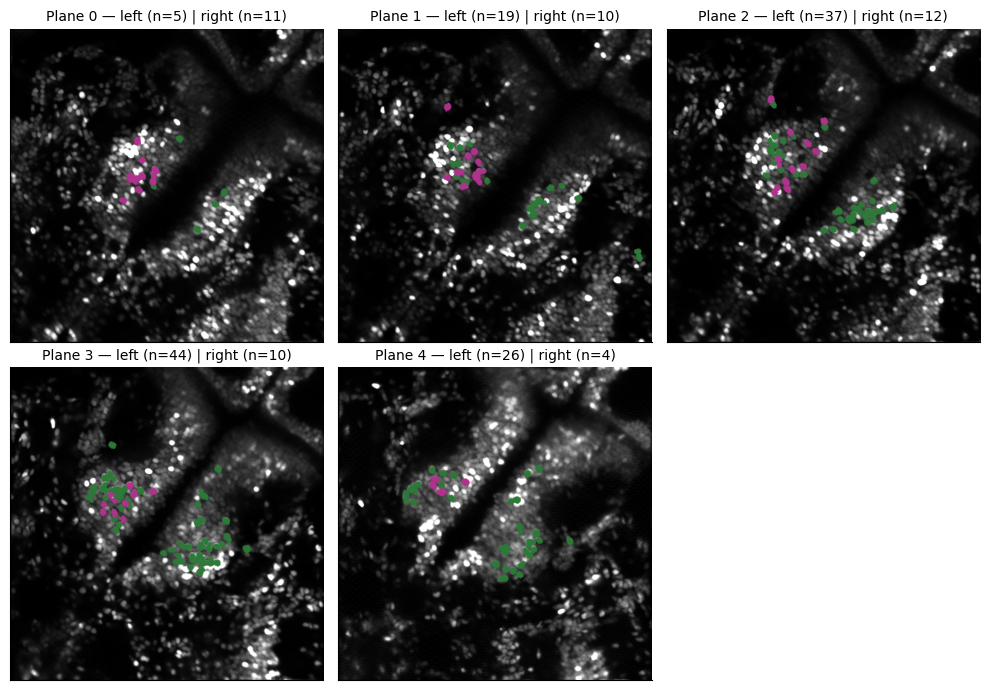

In [99]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # 2 rows × 3 cols
axes = axes.ravel()

for p in range(N_PLANES):  # N_PLANES = 5
    ops = fish.data[f'plane{p}']['ops']
    mean_img = ops['meanImg']

    # --- contrast clipping & normalization (1–99th percentiles) ---
    p1, p99 = np.percentile(mean_img, (1, 99))
    # avoid divide-by-zero if image is flat
    denom = (p99 - p1) if (p99 - p1) != 0 else 1.0
    mean_img_clipped = np.clip(mean_img, p1, p99)
    mean_img_norm = (mean_img_clipped - p1) / denom

    stat_list = fish.data[f'plane{p}']['stat']
    L = left_by_plane[f'plane{p}']
    R = right_by_plane[f'plane{p}']

    ax = axes[p]
    ax.imshow(mean_img_norm, cmap='gray', origin='lower')

    # left-pref (green)
    for li in L:
        st = stat_list[int(li)]
        ax.plot(st['xpix'], st['ypix'], '.', markersize=0.8, color=left_col, alpha=0.7)

    # right-pref (red)
    for ri in R:
        st = stat_list[int(ri)]
        ax.plot(st['xpix'], st['ypix'], '.', markersize=0.8, color=right_col, alpha=0.7)

    # Optional title
    ax.set_title(f"Plane {p} — left (n={len(L)}) | right (n={len(R)})", fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide the unused subplot (6 slots, 5 planes → 1 empty)
for j in range(N_PLANES, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


#### Step 2 - Clustering

##### Affinity Propagation Clustering

Affinity Propagation is a message-passing clustering algorithm that automatically finds an optimal number of clusters and selects **exemplars** — representative data points around which other points are grouped.

Unlike k-means, it does **not require specifying the number of clusters**. It uses a similarity matrix (Negative squared Euclidean distance) and a concept of “preference” to let points compete to become exemplars.

So if two traces are very similar, their distance is small, and their similarity is less negative (closer to 0).
If two traces are very different, their similarity is very negative.

In [69]:
# --- Affinity Propagation to get data-driven clusters + exemplar neurons ---
ap = AffinityPropagation(damping=0.9, random_state=0)
ap_labels = ap.fit_predict(fish.cell_traces[kept_neuron_indices])                            # length = n_neurons
ap_exemplar_indices = ap.cluster_centers_indices_             # indices of exemplar neurons
n_ap_clusters = len(np.unique(ap_labels))
print(f"[AP] Found {n_ap_clusters} clusters.")

[AP] Found 71 clusters.


##### Hierarchical clustering of AP exemplars

We cluster the exemplar traces from Affinity Propagation using agglomerative hierarchical clustering.
Here we use the **complete linkage** method and **correlation distance** to group exemplars with similar activity dynamics.

This produces a dendrogram that shows how exemplars are merged based on similarity.
We can later cut the tree by setting either a number of clusters or a correlation distance threshold.

Other options include:
- **Linkage methods**:
  - `"complete"`: max distance between elements in clusters (compact, tight clusters)
  - `"average"`: average distance between all pairs (balanced, good for noisy data)
  - `"single"`: min distance between elements (can form elongated or chained clusters)
  - `"ward"`: minimizes variance within clusters (only with Euclidean distance)

- **Distance metrics**:
  - `"correlation"`: compares trace shape regardless of amplitude. Focus more on the pattern similarity
  - `"euclidean"`: standard geometric distance (sensitive to amplitude. e.g. two neurons with identical trace shapes but different amplitudes (e.g. one 2× stronger) will be considered different).
  - `"cosine"`: compares angle between traces (scale-invariant)
  - `"cityblock"`: sum of absolute differences (a.k.a. Manhattan distance)

In [70]:
# --- Hierarchical clustering on the AP exemplars (using correlation distance) ---
exemplar_traces = fish.cell_traces[ap_exemplar_indices]                 # matrix: n_exemplars x T
linkage_matrix = linkage(exemplar_traces, method="complete", metric="correlation")

# Choose a distance threshold to get hierarchical cluster labels for the exemplars
DISTANCE_THRESHOLD = 1.1
hier_labels_for_exemplars = fcluster(linkage_matrix, DISTANCE_THRESHOLD, criterion="distance")  # length = n_exemplars
unique_hier_labels, exemplar_index, exemplar_counts = np.unique(hier_labels_for_exemplars, return_index=True, return_counts=True)
n_clusters = len(unique_hier_labels)

In [71]:
# --- Map each neuron to a hierarchical cluster via its AP cluster's exemplar ---
# AP cluster id -> exemplar neuron index
ap_cluster_to_exemplar_idx = {ap_cluster_id: idx for ap_cluster_id, idx in enumerate(ap_exemplar_indices)}

# exemplar neuron index -> hierarchical cluster label
exemplar_idx_to_hier_label = {idx: hlabel for idx, hlabel in zip(ap_exemplar_indices, hier_labels_for_exemplars)}

# Per-neuron hierarchical label (size = n_neurons)
neuron_hier_labels = np.array([exemplar_idx_to_hier_label[ap_cluster_to_exemplar_idx[ap_id]] for ap_id in ap_labels])

# --- Pick the top fraction of hierarchical clusters by neuron count ---
unique_hier_labels, neuron_counts = np.unique(neuron_hier_labels, return_counts=True)

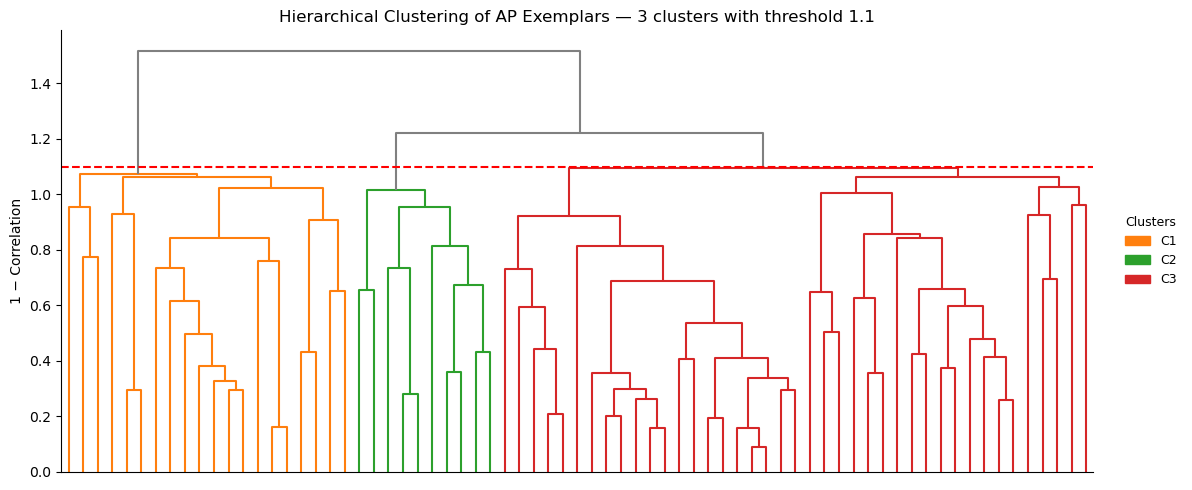

In [72]:
fig, ax = plt.subplots(figsize=(12, 5))
ddata = dendrogram(linkage_matrix, color_threshold=DISTANCE_THRESHOLD, above_threshold_color='gray', ax=ax)

ax.axhline(DISTANCE_THRESHOLD, color='red', linestyle='--', label=f"Threshold = {DISTANCE_THRESHOLD}")
ax.set(title=f"Hierarchical Clustering of AP Exemplars — {n_clusters} clusters with threshold {DISTANCE_THRESHOLD}", ylabel="1 − Correlation", xticks=[], xlabel="")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Map original exemplar index -> dendrogram leaf color
obs_color = dict(zip(ddata['leaves'], ddata['leaves_color_list']))
#
# # Pick one representative exemplar per cluster (first occurrence)
#label_colors = {int(lbl): obs_color.get(int(first_idx[i]), 'gray') for i, lbl in enumerate(uniq_labels)}
label_colors = {int(lbl): obs_color.get(int(exemplar_index[i]), 'gray') for i, lbl in enumerate(unique_hier_labels)}

# Legend
patches = [mpatches.Patch(color=label_colors[lbl], label=f"C{int(lbl)}") for lbl in sorted(label_colors)]
ax.legend(handles=patches, title="Clusters", title_fontsize=9, fontsize=9, bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False)

plt.tight_layout()
plt.show()

/var/folders/vw/c25xvnd9261_m9fn18n8vf040000gn/T/ipykernel_3549/567641320.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


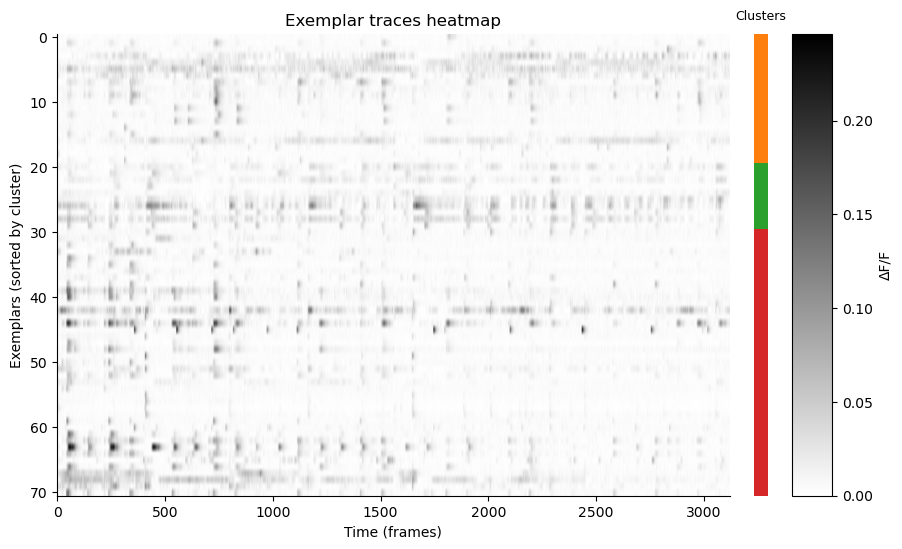

In [73]:
# Traces to plot and sorting by cluster label
sorted_order = np.argsort(hier_labels_for_exemplars)
sorted_exemplar_traces = exemplar_traces[sorted_order]

# Colors for each row (aligned with sorted_idx)
sorted_colors_rgba = np.array([mcolors.to_rgba(obs_color.get(int(i), 'gray')) for i in sorted_order]).reshape(-1, 1, 4)

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[20, 0.4, 1.2], wspace=0.1)

# Main heatmap
ax0 = fig.add_subplot(gs[0])
im = ax0.imshow(sorted_exemplar_traces, aspect='auto', cmap='gray_r', vmin=0.0)
ax0.set_xlabel("Time (frames)")
ax0.set_ylabel("Exemplars (sorted by cluster)")
ax0.set_title("Exemplar traces heatmap")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

# Cluster color strip
ax1 = fig.add_subplot(gs[1])
ax1.imshow(sorted_colors_rgba, aspect='auto')
ax1.axis("off")
ax1.set_title("Clusters", fontsize=9, pad=10)

# ΔF/F colorbar
cax = fig.add_subplot(gs[2])
fig.colorbar(im, cax=cax, label="ΔF/F")

plt.tight_layout()
plt.show()

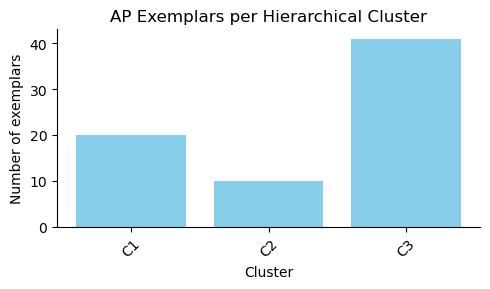

In [74]:
# Plot number of AP exemplars per hierarchical cluster
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(range(len(unique_hier_labels)), exemplar_counts, tick_label=[f"C{l}" for l in unique_hier_labels], color='skyblue')
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of exemplars")
ax.set_title("AP Exemplars per Hierarchical Cluster")
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

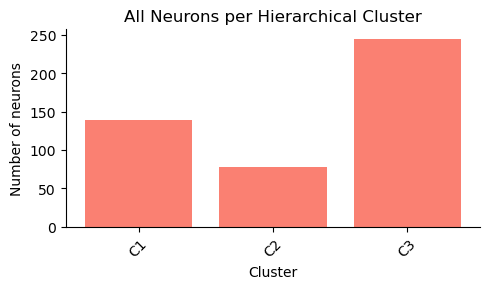

In [75]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(range(len(unique_hier_labels)), neuron_counts, tick_label=[f"C{l}" for l in unique_hier_labels], color='salmon')
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of neurons")
ax.set_title("All Neurons per Hierarchical Cluster")
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

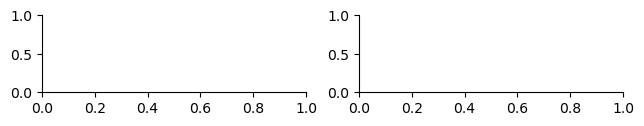

In [76]:
TOP_FRACTION = 0.8  # keep top 80% clusters by size
n_keep = max(1, int(len(unique_hier_labels) * TOP_FRACTION))
top_hier_labels = unique_hier_labels[np.argsort(neuron_counts)[::-1][:n_keep]]

# --- Build: hierarchical cluster label -> exemplar trace (first exemplar seen for that cluster) ---
hier_cluster_to_exemplar_trace = {}
for exemplar_idx, hier_label in zip(ap_exemplar_indices, hier_labels_for_exemplars):
    if hier_label in top_hier_labels and hier_label not in hier_cluster_to_exemplar_trace:
        hier_cluster_to_exemplar_trace[hier_label] = fish.cell_traces[exemplar_idx]

nrows = (n_keep + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(7.5, 0.5 * n_keep), sharex=True)

# Fill down each column first
for i, cluster_label in enumerate(top_hier_labels):
    col = i // nrows      # column index
    row = i % nrows       # row index
    ax = axes[row, col]
    ax.plot(hier_cluster_to_exemplar_trace[cluster_label], linewidth=0.6)
    ax.set_title(f"C{cluster_label} (n={neuron_counts[unique_hier_labels == cluster_label][0]})", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylabel("ΔF/F" if col == 0 else "")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Turn off unused axes
for j in range(len(top_hier_labels), axes.size):
    axes.flat[j].axis("off")

axes[-1, 0].set_xlabel("Time (frames)")
axes[-1, 1].set_xlabel("Time (frames)")
fig.suptitle("Traces of AP exemplars sorted by hierarchical cluster size", fontsize=12)
plt.tight_layout()
plt.show()


#### Step 1 — Sanity-check cluster quality (quick, objective metrics)

#### Step 2 — Stimulus & bout selectivity (ties clusters to behavior)

In [ ]:
# peri-stimulus window in seconds
t_pre_s  = 5.0   # time before onset to include
t_post_s = 10.0  # time after onset to include

# convert to frames
pre_frames  = int(round(t_pre_s * fish.fps_2p))
post_frames = int(round(t_post_s * fish.fps_2p))
print(f"Window: {t_pre_s}s pre ({pre_frames} fr) to {t_post_s}s post ({post_frames} fr)")

# list which stimulus IDs are present in the trace (excluding 0)
present_ids = sorted(int(x) for x in np.unique(fish.stimuli['trace']) if x != 0)
present_names = [fish.stimuli['id_to_name'].get(i, f"id{i}") for i in present_ids]
print("Stimuli present:", list(zip(present_ids, present_names)))

#### Step 3 — Spatial organization